In [23]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
import math
import numpy as np
import matplotlib.pyplot as plt
import logging
logger=tf.get_logger()
logger.setLevel(logging.ERROR)

In [24]:
# loading dataset
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

In [25]:
# exploaring the data
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

Number of training examples: 60000
Number of test examples:     10000


In [26]:
# pre-processing the data
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

# use map function to normalize each element in the train
# and test datasets
train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

# the first time we use the dataset, the images will be loaded from disk
# caching will keep them in memory, making training faster
train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

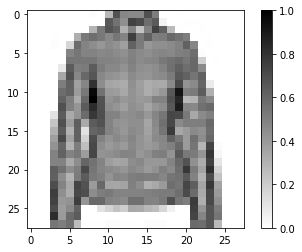

In [27]:
# exploring the processed data

# taking a single image, and removing the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28,28))

# plotting the image
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

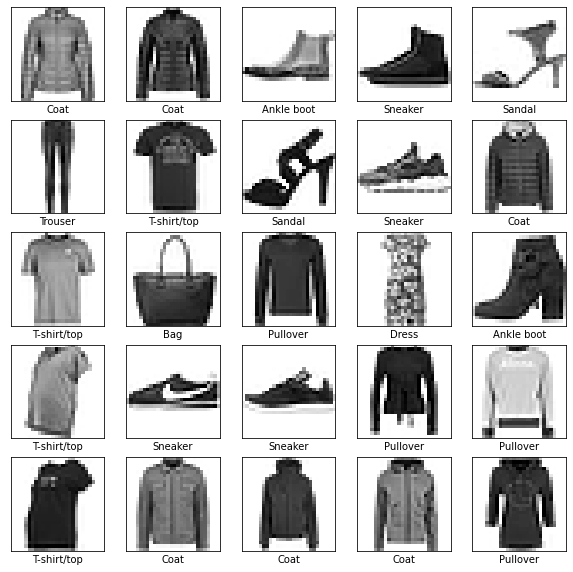

In [28]:
# displaying first 25 images , their class name and checking the format of data
plt.figure(figsize=(10,10))
i = 0
for (image, label) in test_dataset.take(25):
    image = image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
    i += 1
plt.show()

In [29]:
# building the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu,
                           input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [30]:
# compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
# training the model
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

model.fit(train_dataset, epochs=10, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

# Repeat forever by specifying dataset.repeat()
# (the epochs parameter described below limits how long we perform training).
# dataset.shuffle(60000) randomizes the order so our model cannot learn anything from the order of the examples.
# dataset.batch(32) tells model.fit to use batches of 32 images and labels when updating the model variables.


Epoch 1/10
1875/1875 [==============================] - 45s 23ms/step - loss: 0.4004 - accuracy: 0.8547
Epoch 2/10
1875/1875 [==============================] - 44s 23ms/step - loss: 0.2580 - accuracy: 0.9066
Epoch 3/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.2140 - accuracy: 0.9208
Epoch 4/10
1875/1875 [==============================] - 44s 24ms/step - loss: 0.1812 - accuracy: 0.9327
Epoch 5/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1567 - accuracy: 0.9415
Epoch 6/10
1875/1875 [==============================] - 45s 24ms/step - loss: 0.1338 - accuracy: 0.9501
Epoch 7/10
1875/1875 [==============================] - 46s 24ms/step - loss: 0.1121 - accuracy: 0.9587
Epoch 8/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0966 - accuracy: 0.9644
Epoch 9/10
1875/1875 [==============================] - 46s 25ms/step - loss: 0.0783 - accuracy: 0.9714
Epoch 10/10
1875/1875 [==============================] - 45s 24m

In [32]:
# evaluating accuracy
test_loss, test_accuracy = model.evaluate(test_dataset, steps=math.ceil(num_test_examples/32))
print('Accuracy on test dataset:', test_accuracy)

313/313 [==============================] - 3s 8ms/step - loss: 0.3251 - accuracy: 0.9184
Accuracy on test dataset: 0.91839998960495


In [33]:
# making predictions
for test_images, test_labels in test_dataset.take(1):
    test_images = test_images.numpy()
    test_labels = test_labels.numpy()
    predictions = model.predict(test_images)

In [35]:
predictions.shape


(32, 10)

In [36]:
predictions[0]

array([6.1786881e-11, 7.8420826e-13, 1.4741511e-04, 1.2131278e-09,
       9.9910188e-01, 1.2513418e-11, 7.5070537e-04, 1.6227878e-12,
       1.0647027e-09, 7.9878522e-09], dtype=float32)

In [37]:
np.argmax(predictions[0])

4

In [38]:
test_labels[0]

4

In [39]:
# model is usually most confident that this image belongs to class_names[4].


4

In [40]:
# making a graph to look at the full set of 10 class predictions
def plot_image(i, predictions_array, true_labels, images):
    predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img[...,0], cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

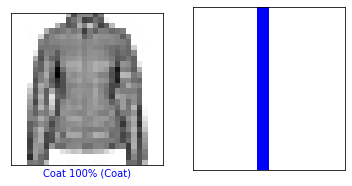

In [41]:
# looking at prediction of of 0th image in array
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

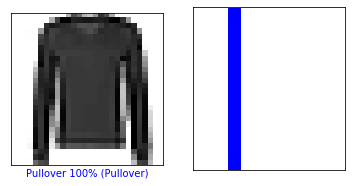

In [43]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

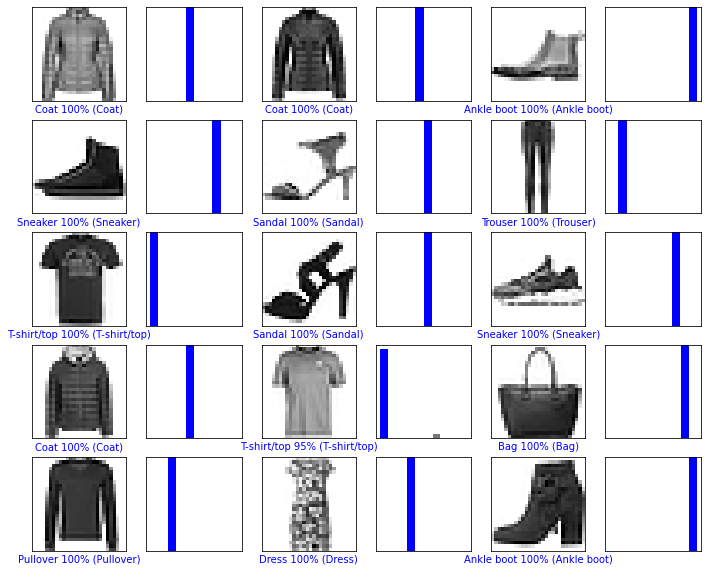

In [44]:
#plotting several images with their predictions. correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label.


# plotting the first X test images, their predicted label, and the true label

num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

In [45]:
# using trained model to make a prediction on single image

# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [46]:
# tf.keras models are optimized to make predictions on a batch, or collection, of examples at once. So even though we're using a single image, we need to add it to a list:

# adding the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [47]:
# predicting the image
predictions_single = model.predict(img)

print(predictions_single)

[[6.17871171e-11 7.84206738e-13 1.47415252e-04 1.21313015e-09
  9.99101877e-01 1.25133705e-11 7.50705018e-04 1.62278784e-12
  1.06470255e-09 7.98785127e-09]]


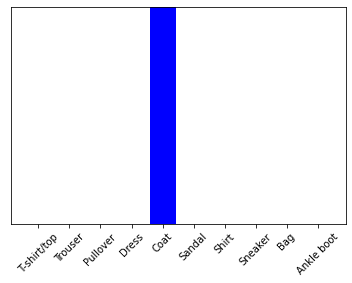

In [48]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [49]:
np.argmax(predictions_single[0])

4